In [1]:
!pip install -U ppscore

     |████████████████████████████████| 46 kB 880 kB/s 
  Created wheel for ppscore: filename=ppscore-1.1.0-py2.py3-none-any.whl size=12944 sha256=f59f5a0e31f39418432c57e20bc6adc8fdc3d7c14d76ee2a0d54723d65eef676
  Stored in directory: /root/.cache/pip/wheels/9c/e3/8c/e59f7724864a3f1a3e40f9a748dd032fc3e25e77aaa2f46e0b
Successfully built ppscore
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import ppscore as pps

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")
pd.options.plotting.backend = "plotly"

data = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

# Content

<ul style="font-size: 22px">
    <li>Facts related to heart Failure</li>
    <li>Description of Data</li>
    <li>Correlation in the Data</li>
    <li>Outliers in Data</li>
    <li>Relation between variables</li>
</ul>

<h1>Heart Failure</h1>

<p>Heart failure happens when the heart cannot pump enough blood and oxygen to support other organs in your body. Heart failure is a serious condition, but it does not mean that the heart has stopped beating.</p>

<h1>Facts About Heart Failure</h1>

<ul>
    <li>About 6.5 million adults in the United States have heart failure.</li>
    <li>Heart failure was a contributing cause of 1 in 8 deaths in 2017.</li>
    <li>Heart failure costs the nation an estimated $30.7 billion in 2012. This total includes the cost of health care services, medicines to treat heart failure, and missed days of work.<a href="https://www.cdc.gov/heartdisease/heart_failure.htm">Source</a></li>
</ul>

<img src="https://timesofindia.indiatimes.com/thumb/msid-71058199,width-1200,height-900,resizemode-4/.jpg" height="500px" width="500px">

# Description of Data

In [3]:
fig = data.nunique().reset_index().plot(kind='bar', x='index', y=0, color=0)
fig.update_layout(title='Unique Value Count Plot', xaxis_title='Variables', yaxis_title='Unique value count')
fig.show()

In [4]:
fig = data.isnull().sum().reset_index().plot(kind='bar', x='index', y=0)
fig.update_layout(title='Missing Value Plot', xaxis_title='Variables', yaxis_title='Missing value count')
fig.show()

<p style="font-size:18px">No missing values present. That's a good news. Let's check the data types as well to make sure variables don't have mized type of data here.</p>

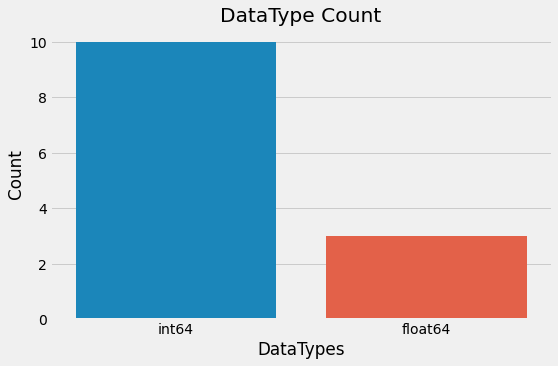

In [5]:
df = data.dtypes.value_counts().reset_index()
df['index'] = df['index'].astype('str')
sns.barplot(df['index'], df[0])
plt.title('DataType Count')
plt.xlabel('DataTypes')
plt.ylabel('Count')
plt.show()

# Correlation in the data

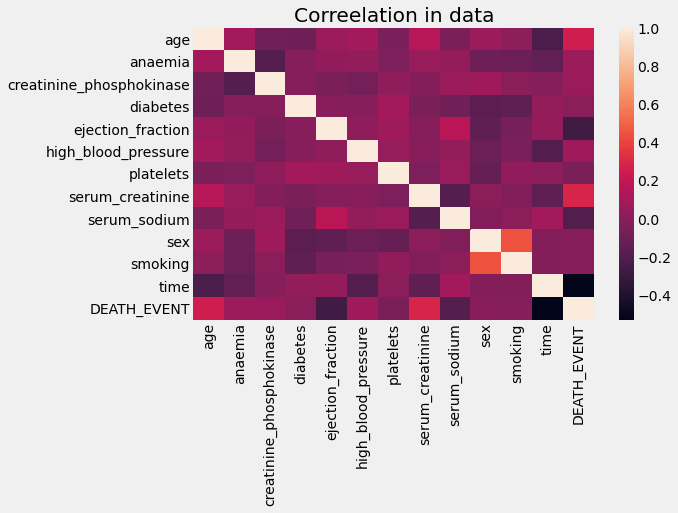

In [6]:
sns.heatmap(data.corr())
plt.title('Correelation in data')
plt.show()

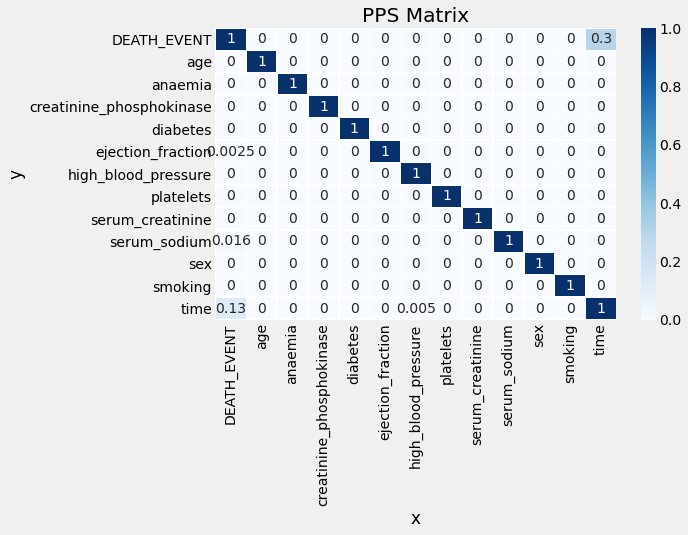

In [7]:
matrix_df = pps.matrix(data)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('PPS Matrix')
plt.show()

# Outliers in the data

<p style="font-size:17px">The variables which I will need to check for outliers are mostly the continuous variables and not the categorical ones.<br><br>Since I have already confirmed the datatypes, categorical variables are already clean.<br><br>
So i will check thing for age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium and time</p>

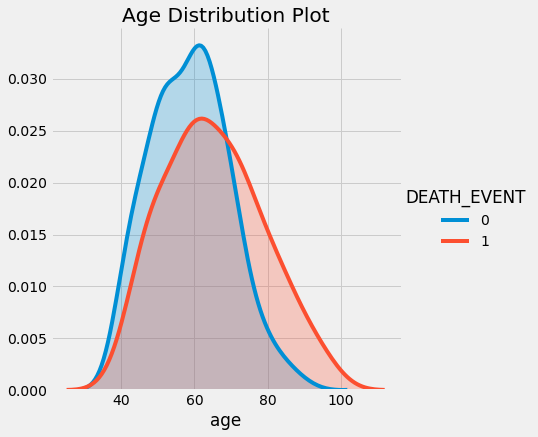

In [8]:
sns.FacetGrid(data, hue="DEATH_EVENT", height=6,).map(sns.kdeplot, "age",shade=True).add_legend()
plt.title('Age Distribution Plot')
plt.show()

In [9]:
px.box(data, x='DEATH_EVENT', y='creatinine_phosphokinase', color='smoking', title='Creatinine Phosphokinase Distribution')

<p style="font-size:18px">The variable creatinine_phosphokinase possibly denotes the amount of creatinine phosphokinase(an enzyme in human body) in the body of the person tested.<br><br>From the above plot it can be inferred that any amount of the enzyme higher than 4000 is an outlier.</p>

In [10]:
px.violin(data, x='ejection_fraction', color='DEATH_EVENT', title='Ejection Fraction Distribution')

In [11]:
px.box(data, x='DEATH_EVENT', y='platelets', color='diabetes', points='all', title='Platelets Distribution')

In [12]:
px.box(data, x='DEATH_EVENT', y='time', color='smoking', notched=True, title='Time under observation Distribution')

# Relation in the data

<p style="font-size:18px">From general convention the relation among the variables that might be interesting are<br><br>1. high_blood_pressure and platelets<br>2. diabetes, serum_sodium and serum_creatinine<br>3. time and DEATH_EVENT</p>

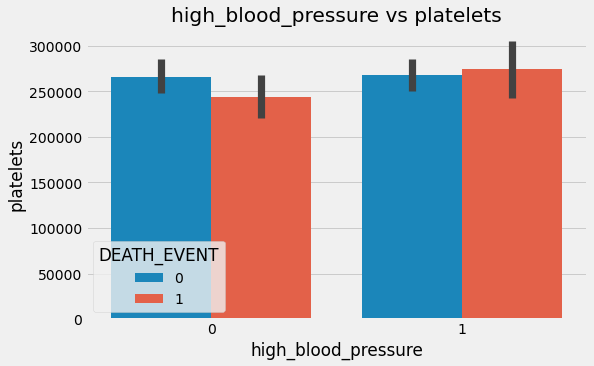

In [13]:
sns.barplot(data=data, x='high_blood_pressure', y='platelets', hue='DEATH_EVENT')
plt.title('high_blood_pressure vs platelets')
plt.show()

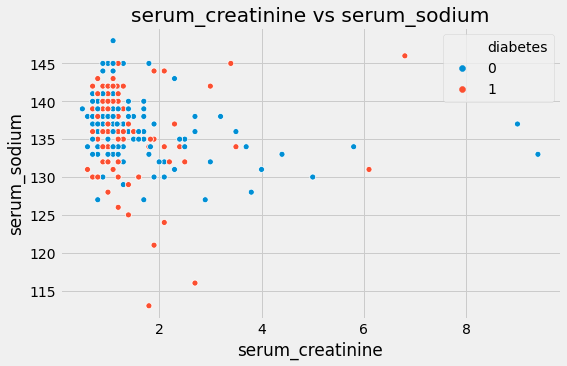

In [14]:
sns.scatterplot(data=data, x='serum_creatinine', y='serum_sodium', hue='diabetes')
plt.title('serum_creatinine vs serum_sodium')
plt.show()

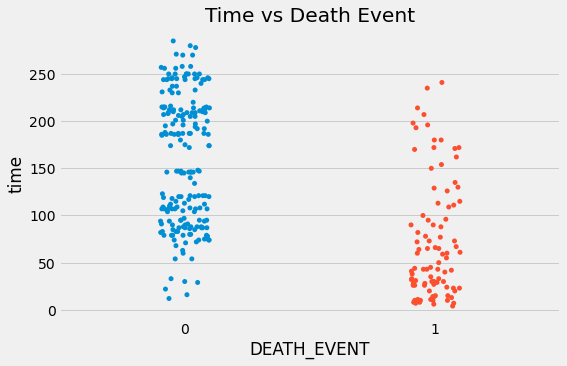

In [15]:
sns.stripplot(data=data, x="DEATH_EVENT", y="time")
plt.title('Time vs Death Event')
plt.show()

<p style="font-size:18px">In the next version I will be adding a model. Do leave an upvote if you like the analysis so far.</p>